In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Grid size
GRID_SIZE = 20

In [3]:
# Randomly generate blocked squares and gold position
np.random.seed()  # Different for each run
blocked_squares = set((np.random.randint(GRID_SIZE), np.random.randint(GRID_SIZE)) for _ in range(GRID_SIZE//2))




In [4]:
NUM_BLOCKED = 90

blocked_squares = set()
while len(blocked_squares) < NUM_BLOCKED:
    bx, by = np.random.randint(GRID_SIZE), np.random.randint(GRID_SIZE)
    blocked_squares.add((bx, by))

In [23]:
gold_position = (np.random.randint(GRID_SIZE), np.random.randint(GRID_SIZE))
while gold_position in blocked_squares:  # Ensure gold isn't in a blocked square
    gold_position = (np.random.randint(GRID_SIZE), np.random.randint(GRID_SIZE))

In [6]:
# Define rewards
REWARD_STEP = -1
REWARD_GOLD = 200


In [7]:
# Initialize value function
V = np.zeros((GRID_SIZE, GRID_SIZE))

In [8]:
# Define actions (up, down, left, right)
# first coordinate correspondes to change in Row index ,
# second coordinate corresponds to change in Column index
actions = {
    0: (-1, 0),  # Up
    1: (1, 0),   # Down
    2: (0, -1),  # Left
    3: (0, 1)    # Right
}

In [9]:
# Hyperparameters
gamma = 0.99  # Discount factor
theta = 1e-6  # Convergence threshold
max_iterations = 1000
p_intended = 0.9  # Probability of intended move
p_random = 0.1  # Probability of moving randomly

In [10]:
def is_valid(x, y):
    """Check if a position is within bounds and not blocked."""
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and (x, y) not in blocked_squares

In [11]:
## return an array whose elements are of the form (p,a,b), where after taking the action from position (x,y), the agent
##  moves to state (a,b) with probability p


def get_transition_probabilities(x, y, action):
    """
    Returns a list of (probability, next_x, next_y) tuples
    for the stochastic transitions from (x, y) using `action`.
    """
    intended_dx, intended_dy = actions[action]
    intended_x, intended_y = x + intended_dx, y + intended_dy

    # If intended move is invalid, stay in place
    if not is_valid(intended_x, intended_y):
        intended_x, intended_y = x, y

    transitions = [(p_intended, intended_x, intended_y)]

    # Select a random other action
    other_actions = [a for a in actions if a != action]
    for other_action in other_actions:
        rand_dx, rand_dy = actions[other_action]
        rand_x, rand_y = x + rand_dx, y + rand_dy
        if not is_valid(rand_x, rand_y):
            rand_x, rand_y = x, y
        transitions.append((p_random / len(other_actions), rand_x, rand_y))

    return transitions

In [12]:
get_transition_probabilities(0, 0, 1)

[(0.9, 1, 0),
 (0.03333333333333333, 0, 0),
 (0.03333333333333333, 0, 0),
 (0.03333333333333333, 0, 1)]

In [30]:
def value_iteration():
    """
    Write this function to perform value iteration on the grid
    """
    for i in range(max_iterations):
        delta = 0
        new_V = np.zeros((GRID_SIZE, GRID_SIZE))
        for x in range(GRID_SIZE):
            for y in range(GRID_SIZE):
                if (x, y) == gold_position:
                    new_V[x, y] = REWARD_GOLD
                elif (x, y) in blocked_squares:
                    new_V[x, y] = 0
                else:
                    best_reward = float('-inf')
                    for action in actions:
                        reward = 0
                        for p, a, b in get_transition_probabilities(x, y, action):
                            reward += p * (REWARD_STEP + gamma * V[a, b])
                        best_reward = max(best_reward, reward)

                    new_V[x, y] = best_reward
                    delta = max(delta, abs(new_V[x, y] - V[x, y]))
        if delta < theta:
            break

In [31]:
def extract_policy():
    """
    Write this function to extract the optimal policy from the computed value function.
    """
    policy = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            if (x, y) == gold_position:
                policy[x, y] = -1
            elif (x, y) in blocked_squares:
                policy[x, y] = -1
            else:
                policy[x, y] = np.argmax([sum(p * (REWARD_STEP + gamma * V[a, b]) for p, a, b in get_transition_probabilities(x, y, action)) for action in actions])

    # Convert integer actions to arrow characters
    # An attempt to replicate the assignment's output
    policy_chars = np.empty((GRID_SIZE, GRID_SIZE), dtype='U1')
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if policy[i, j] == -1:
                policy_chars[i, j] = '█'
            elif policy[i, j] == 0:
                policy_chars[i, j] = '↑'
            elif policy[i, j] == 1:
                policy_chars[i, j] = '↓'
            elif policy[i, j] == 2:
                policy_chars[i, j] = '←'
            elif policy[i, j] == 3:
                policy_chars[i, j] = '→'
    return policy_chars




Optimal Policy Grid:
→ → ↓ ← ← ← █ → ↓ █ ↓ ↓ ← ← █ ↓ ↓ ← █ ↓
→ → ↓ ← ← ← █ █ → ↓ ↓ ↓ ← █ █ ↓ ← █ → ↓
↑ █ ↓ █ █ █ █ ↓ █ ↓ ← ← █ ↓ ← ← ← ← █ ↓
█ █ → ↓ ↓ → ↓ ↓ ↓ ← ← ← ← ← ← █ ↓ █ ↓ ←
→ → → ↓ ↓ █ ↓ ↓ ↓ █ ↑ ← ← ← ← ← ← ← ← ←
→ → → → → ↓ ↓ ↓ ↓ █ █ █ █ █ ↑ ↓ █ ↓ ↓ █
→ → → → → ↓ ↓ ← ← ← ← █ → ↓ █ ↓ ↓ ← ← ←
→ ↓ ↓ █ █ ↓ ← ← ← ← ← ← █ ↓ █ ↓ ← ← ← ←
→ ↓ ↓ █ █ ← ← ← █ █ ↑ ↑ ← ← ← ← ← ← █ ↑
█ → ↓ █ ↑ ← ← ← ← ← █ ↑ ← ← ← ← ← ← ← █
↑ █ → → ↑ ↑ ← ← █ ↑ █ ↑ █ █ ↑ ↑ ← █ ↑ ←
█ ↓ █ █ ↑ ↑ ↑ ↑ ← ← ← █ → → ↑ ↑ ↑ ← ← ←
→ → → ↓ █ ↑ ↑ ← ← ← █ ↑ █ ↓ ↑ ↑ ↑ █ ↑ ↑
→ → → → → ↑ █ ↑ █ █ ↓ █ ↓ ← █ ↑ █ █ ↑ █
↑ ↑ █ → ↑ ↑ ← ↑ ← ← ← ← ← ← ← ← ← ← ← █
→ → → ↑ ↑ ↑ ↑ ↑ ← ← ← █ █ ↑ █ ↑ ↑ █ ↑ ←
→ → → ↑ ↑ ↑ ↑ ↑ █ ↑ ↑ █ ↑ █ → ↑ ↑ █ ↑ ↑
↑ → → ↑ ↑ ↑ ↑ ↑ ← ↑ ↑ █ █ ↓ ↑ █ ↑ ← ← ←
↑ ↑ ↑ █ ↑ █ █ ↑ ↑ ↑ █ ↓ ← ← ← █ █ ↑ ↑ ↑
↑ █ ↑ █ ↑ █ → ↑ ↑ ↑ ← ← ← ← █ → → ↑ ↑ █


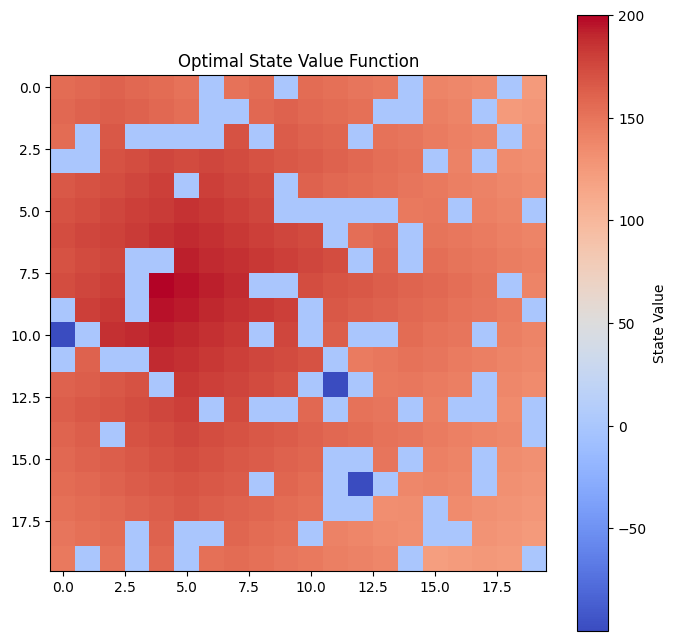

In [32]:
# Run Value Iteration
value_iteration()

# Extract and visualize policy
optimal_policy = extract_policy()

print("\nOptimal Policy Grid:")
for row in optimal_policy:
    print(" ".join(row))

# Plot the Value Function
plt.figure(figsize=(8, 8))
plt.imshow(V, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="State Value")
plt.title("Optimal State Value Function")
plt.show()


In [24]:
gold_position

(8, 4)